In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sns.set(context='notebook', style='white', font_scale=1.2)

In [2]:
try:
    import crossmapy as cmp
except:
    import sys
    sys.path.append('../')
    import crossmapy as cmp

In [3]:
res_dir = f'results/covid19/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [15]:
def main():
    embed_dim = 20
    n_neighbor = 3
    GC = cmp.GrangerCausality(embed_dim=embed_dim)
    TE = cmp.TransferEntropy(embed_dim=embed_dim)
    CCM = cmp.ConvergeCrossMapping(embed_dim=embed_dim, n_neighbor=n_neighbor)
    PCM = cmp.PartialCrossMapping(embed_dim=embed_dim, n_neighbor=n_neighbor)
    CMC = cmp.CrossMappingCardinality(embed_dim=embed_dim, n_neighbor=n_neighbor)
    DCMC = cmp.DirectCrossMappingCardinality(embed_dim=embed_dim, n_neighbor=n_neighbor)
    
    methods = [GC, TE, CCM, PCM, CMC, DCMC]
    labels = ['GC', 'TE', 'CCM', 'PCM', 'CMC', 'DCMC']
    
    data_ = np.load(f'../data/covid19/covid19_JP.npy')
    data = data_[1:] - data_[:-1]
    res_dir = f'results/covid19/'
    for i, method in enumerate(methods):
        method.fit(data)
        np.save(f'{res_dir}method{labels[i]}.npy', method.scores)
        print(f'method {labels[i]} complete!')

In [16]:
main()

method GC complete!
method TE complete!
method CCM complete!


..\crossmapy\utils.py:192: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(compute_squared_distance_vec(X))


method PCM complete!
method CMC complete!
method DCMC complete!


In [24]:
data_ = np.load(f'../data/covid19/covid19_JP.npy')
data = data_[1:] - data_[:-1]

In [17]:
names = [
    'Hokkaido',
    'Aomori',
    'Iwate',
    'Miyagi',
    'Akita',
    'Yamagata',
    'Fukushima',
    'Ibaraki',
    'Tochigi',
    'Gunma',
    'Saitama',
    'Chiba',
    'Tokyo',
    'Kanagawa',
    'Niigata',
    'Toyama',
    'Ishikawa',
    'Fukui',
    'Yamanashi',
    'Nagano',
    'Gifu',
    'Shizuoka',
    'Aichi',
    'Mie',
    'Shiga',
    'Kyoto',
    'Osaka',
    'Hyogo',
    'Nara',
    'Wakayama',
    'Tottori',
    'Shimane',
    'Okayama',
    'Hiroshima',
    'Yamaguchi',
    'Tokushima',
    'Kagawa',
    'Ehime',
    'Kochi',
    'Fukuoka',
    'Saga',
    'Nagasaki',
    'Kumamoto',
    'Oita',
    'Miyazaki',
    'Kagoshima',
    'Okinawa'
]

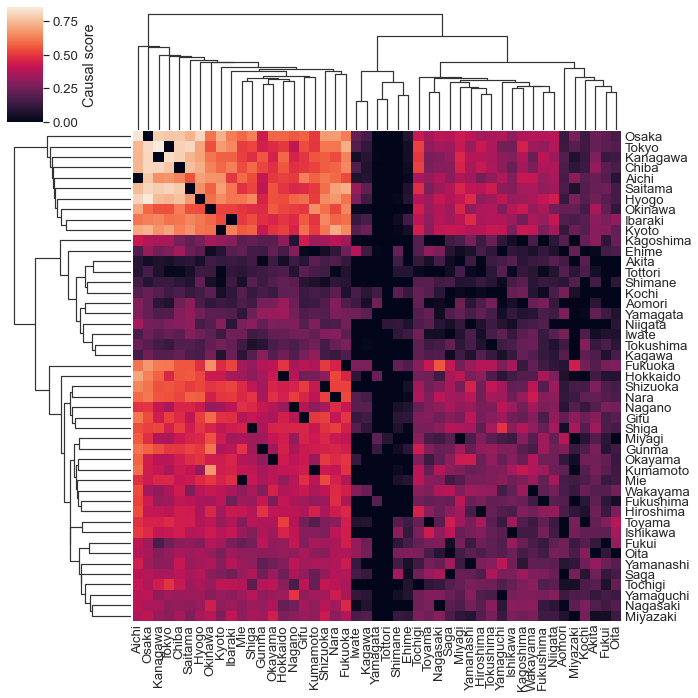

In [18]:
resfile = f'{res_dir}methodDCMC.npy'
mat = np.load(resfile)
G = sns.clustermap(mat, xticklabels=names, yticklabels=names, tree_kws={'lw': 1.2},
                   cbar_pos=(0.02, 0.82, 0.05, 0.16), cbar_kws={'label': 'Causal score'})
G.ax_heatmap.tick_params(length=0)

In [19]:
import math
def transform_lng_lat_to_xyz(lng_lat):
    lng, lat = lng_lat
    x = math.cos(math.radians(lat)) * math.cos(math.radians(lng))
    y = math.cos(math.radians(lat)) * math.sin(math.radians(lng))
    z = math.sin(math.radians(lat))
    return np.array([x, y, z])

def cal_geodesic_distance(lng_lat1, lng_lat2, R=6371.393):
    v1 = transform_lng_lat_to_xyz(lng_lat1)
    v2 = transform_lng_lat_to_xyz(lng_lat2)
    tmp = np.sum(v1 * v2) / math.sqrt(np.sum(v1**2) * np.sum(v2**2))
    geo_dis = math.acos(tmp) * R
    return geo_dis

In [38]:
jp_loc_df = pd.read_csv(r'..\data\covid19\jp_pref_loc.csv')
cor_dict = {item[1]: [item[2], item[3]] for item in jp_loc_df.itertuples()}

dist_list = []
for n in names:
    if n != 'Tokyo':
        dist = cal_geodesic_distance(cor_dict[n], cor_dict['Tokyo'])
        dist_list.append(dist)

In [44]:
score_list = list(mat[names.index('Tokyo')])
del score_list[names.index('Tokyo')]

pep_list = list(data_[-1])
del pep_list[names.index('Tokyo')]

size_list = [0.1*i for i in pep_list] # [np.log10(i) for i in pep_list]

tmp_name = names[:]
del tmp_name[names.index('Tokyo')]

In [45]:
top_index = np.argsort(pep_list)[::-1]
dist_ = [dist_list[top_index[i]] for i in range(10)]
score_ = [score_list[top_index[i]] for i in range(10)]
name_ = [tmp_name[top_index[i]] for i in range(10)]
size_ = [size_list[top_index[i]] for i in range(10)]

In [46]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
x = np.array(dist_).reshape(-1,1)
y = np.array(score_)
model.fit(x, y)
model.score(x, y) #R2

0.6695355777974916

In [47]:
x_point = np.linspace(-100, 1600, 100)
y_point = model.coef_ * x_point + model.intercept_

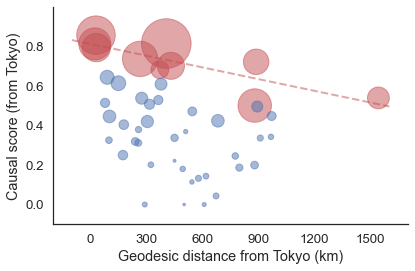

In [48]:
colors = ['r' if i in name_ else 'b' for i in tmp_name]

fig, ax = plt.subplots()
ax.scatter(dist_list, score_list, s=size_list, alpha=.5, color=colors)
ax.plot(x_point, y_point, lw=2, alpha=.5, c='r', ls='--')
ax.set_xlim(-200, 1700)
ax.set_ylim(-0.1, 1.)
ax.set_xticks(np.arange(0, 1600, 300))
ax.set_yticks(np.arange(0, 1, 0.2))
ax.set_xlabel('Geodesic distance from Tokyo (km)')
ax.set_ylabel('Causal score (from Tokyo)')
sns.despine(ax=ax)
plt.tight_layout()

In [52]:
for s, n in zip(score_, name_):
    print(n, s)

Osaka 0.8146245059117767
Kanagawa 0.8570291968459753
Aichi 0.7368834150320338
Hokkaido 0.5008884698569407
Saitama 0.8128590947610881
Chiba 0.7941283263451229
Hyogo 0.7018655303492631
Fukuoka 0.722130692199273
Okinawa 0.5393942885697731
Kyoto 0.6822667352936613


In [60]:
date = pd.date_range(start="20200115", end="20201213", freq="D").date

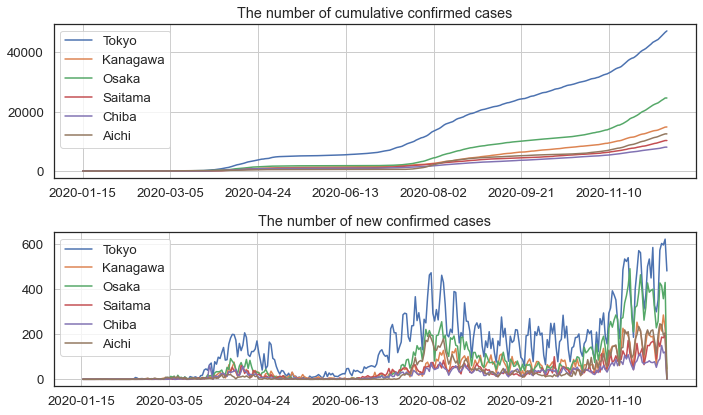

In [61]:
prefs = ['Tokyo', 'Kanagawa', 'Osaka', 'Saitama', 'Chiba', 'Aichi']
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
for i, v in enumerate(prefs):
    ax[0].plot(data_[:, names.index(v)], label=v)
ax[0].set_title('The number of cumulative confirmed cases')

for i, v in enumerate(prefs):
    ax[1].plot(range(1, data_.shape[0]), data[:, names.index(v)], label=v)
ax[1].set_title('The number of new confirmed cases')

for i in range(2):
    ax[i].legend()
    ax[i].set_xticks(np.arange(0, 350, 50))
    ax[i].set_xticklabels(date[::50])
    ax[i].grid()
plt.tight_layout()